In [1]:
%cd /content/drive/MyDrive/Paper

/content/drive/MyDrive/Paper


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [3]:
Data_path = '/content/drive/MyDrive/Paper/Data'

In [4]:
# List all the labels and the number of images in each label
image_labels = sorted(os.listdir(Data_path))
num_classes = len(image_labels)
print("Number of classes:", num_classes)

print(image_labels)
for label in image_labels:
    print('{}: {} images'.format(label, len(os.listdir(Data_path + '/' + label))))

Number of classes: 3
['metal', 'paper', 'plastic']
metal: 960 images
paper: 970 images
plastic: 1050 images


In [5]:

def read_image(image_path):
    image = []
    labels = []

    for label, class_name in enumerate(os.listdir(image_path)):
        for image_name in os.listdir(os.path.join(image_path, class_name)):
            img = cv2.imread(os.path.join(image_path, class_name, image_name))
            img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_LINEAR_EXACT)
            image.append(img)
            labels.append(label)

    return image, labels
def one_hot_encoding(image,labels):
    image = np.array(image, dtype='float32') / 255.0
    LB = LabelBinarizer()
    labels = LB.fit_transform(np.array(labels))
    return image, labels

def split_data(image, labels, val_ratio, test_ratio):
    # Split the dataset into train, validation, and test sets
    train_images, val_test_images, train_labels, val_test_labels = train_test_split(image, labels, test_size=val_ratio+test_ratio, shuffle=True, random_state=42)
    val_images, test_images, val_labels, test_labels = train_test_split(val_test_images, val_test_labels, test_size=(test_ratio/(val_ratio+test_ratio)), shuffle=True, random_state=42)
    return train_images, val_images, test_images, train_labels, val_labels, test_labels





In [6]:
train_aug = ImageDataGenerator(rotation_range=180,
                               zoom_range=0.3,
                               horizontal_flip=True,
                               vertical_flip =True )
val_aug = ImageDataGenerator()

In [7]:
images, labels = read_image(Data_path)
images, labels = one_hot_encoding(images, labels)
train_images, val_images, test_images, train_labels, val_labels, test_labels = split_data(images, labels, 0.151, 0.151)

print(train_images.shape, val_images.shape, test_images.shape)


(2080, 224, 224, 3) (450, 224, 224, 3) (450, 224, 224, 3)


In [8]:

train_aug_data = train_aug.flow(train_images, train_labels, batch_size=32)
val_aug_data = val_aug.flow(val_images, val_labels, batch_size=32)

In [9]:
dense_net = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
dense_net.trainable = True

GAP = GlobalAveragePooling2D()
FC1 = Dense(1024, activation = 'relu')
D1  = Dropout(0.2)
FC2 = Dense(num_classes, activation = 'softmax')

model = Sequential([dense_net, GAP, FC1, D1, FC2], name = 'Dense-new-Model')
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "Dense-new-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 8090179 (30.86 MB)
Trainable params: 8

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_Dense.h5', verbose=1, save_best_only=True)

history_Dense = model.fit(train_aug_data,
                          steps_per_epoch = train_images.shape[0] // 32,
                          epochs = 20,
                          verbose = 2,
                          callbacks = [anne, checkpoint],
                          validation_data = val_aug_data,
                          validation_steps = val_images.shape[0] // 32)


Epoch 1/20

Epoch 1: val_loss improved from inf to 0.34432, saving model to model_Dense.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 - 114s - loss: 0.4575 - accuracy: 0.8125 - val_loss: 0.3443 - val_accuracy: 0.8616 - lr: 1.0000e-04 - 114s/epoch - 2s/step
Epoch 2/20

Epoch 2: val_loss improved from 0.34432 to 0.23364, saving model to model_Dense.h5
65/65 - 38s - loss: 0.1900 - accuracy: 0.9317 - val_loss: 0.2336 - val_accuracy: 0.9085 - lr: 1.0000e-04 - 38s/epoch - 577ms/step
Epoch 3/20

Epoch 3: val_loss did not improve from 0.23364
65/65 - 36s - loss: 0.1447 - accuracy: 0.9505 - val_loss: 0.2571 - val_accuracy: 0.9040 - lr: 1.0000e-04 - 36s/epoch - 548ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 0.23364
65/65 - 34s - loss: 0.1075 - accuracy: 0.9591 - val_loss: 0.2459 - val_accuracy: 0.9219 - lr: 1.0000e-04 - 34s/epoch - 529ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.23364 to 0.16694, saving model to model_Dense.h5
65/65 - 40s - loss: 0.0902 - accuracy: 0.9654 - val_loss: 0.1669 - val_accuracy: 0.9397 - lr: 1.0000e-04 - 40s/epoch - 612ms/step
Epoch 6/20

Epoch 6: val_loss improved from

In [11]:

def plot_train_result(history):
    Accuracy = history.history['accuracy']
    Val_accuracy = history.history['val_accuracy']
    Loss = history.history['loss']
    Val_loss = history.history['val_loss']
    #Lr = history.history['lr']
    Epochs = range(1, len(Accuracy) + 1)

    fig, axes = plt.subplots(1, 2, figsize = (15, 5))

    axes[0].plot(Epochs, Accuracy, 'r', label = 'Training accuracy')
    axes[0].plot(Epochs, Val_accuracy, 'g', label = 'Validation accuracy')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend(loc = 'lower right')
    axes[0].set_xlabel('Epoch', fontsize = 16)
    axes[0].set_ylabel('Accuracy', fontsize = 16)

    axes[1].plot(Epochs, Loss, 'r', label = 'Training loss')
    axes[1].plot(Epochs, Val_loss, 'g', label = 'Validation loss')
    axes[1].set_title('Training and validation loss')
    axes[1].legend(loc = 'upper right')
    axes[1].set_xlabel('Epoch', fontsize = 16)
    axes[1].set_ylabel('Loss', fontsize = 16)

    #axes[2].plot(Epochs, Lr, 'b')
    #axes[2].set_title('Reduce Learning Rate on Plateau')
    #axes[2].set_xlabel('Epoch', fontsize = 16)
    #axes[2].set_ylabel('Learning rate', fontsize = 16)

    plt.tight_layout()
    plt.show()


In [12]:

def test_result(image_predictions, test_labels):
    y_true = np.argmax(test_labels, axis=1)
    y_pred = np.argmax(image_predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred)

    print('Confusion Matrix:')
    print(cm)
    print('\nClassification Report:')
    print(clr)

    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print('\nTest Accuracy:', round(accuracy * 100, 2), '%')

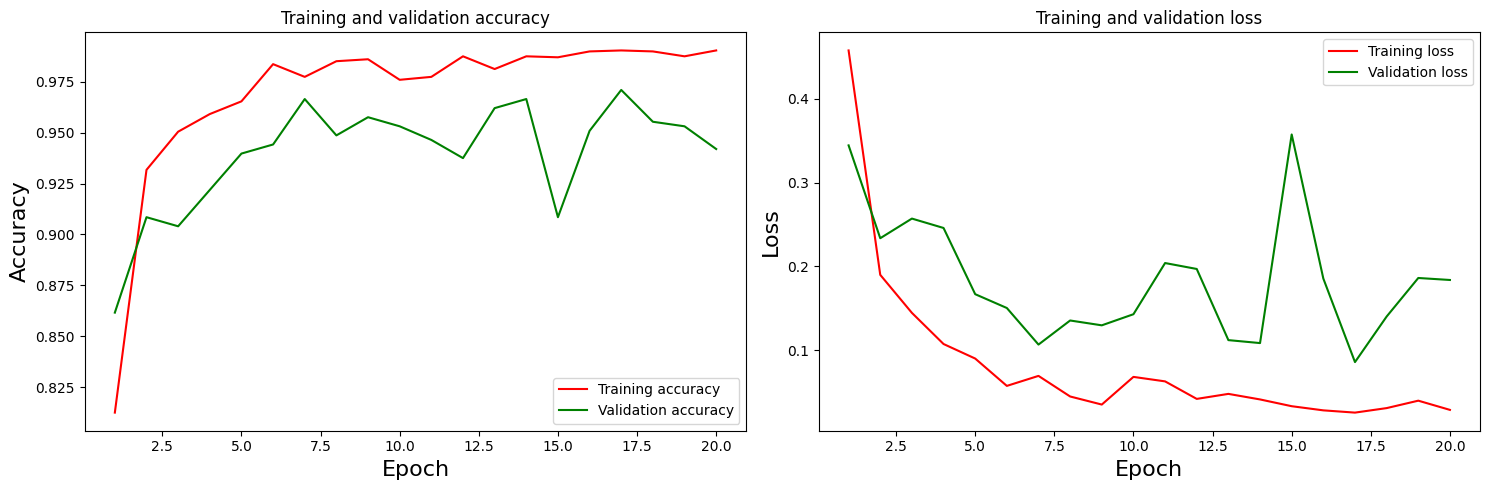

In [13]:
plot_train_result(history_Dense)

In [15]:
model = tf.keras.models.load_model('model_Dense.h5')
image_predictions = model.predict(test_images)
test_result(image_predictions, test_labels)


15/15 [==============================] - 6s 237ms/step
Confusion Matrix:
[[146   4   5]
 [  3 134   0]
 [  3   0 155]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       155
           1       0.97      0.98      0.97       137
           2       0.97      0.98      0.97       158

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450


Test Accuracy: 96.67 %


In [16]:
def save_structure_data(data_path, train_images, val_images, test_images, train_labels, val_labels, test_labels):
    # Create train, val, and test folders
    train_path = os.path.join(data_path, 'train')
    val_path = os.path.join(data_path, 'val')
    test_path = os.path.join(data_path, 'test')
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Move the images to the corresponding class directories in the train folder
    for image, label in zip(train_images, train_labels):
        class_folder = os.path.join(train_path, str(label))
        os.makedirs(class_folder, exist_ok=True)
        image_name = f"{label}_{random.randint(0, 100000)}.jpg"
        image_path = os.path.join(class_folder, image_name)
        cv2.imwrite(image_path, image)

    # Move the images to the corresponding class directories in the validation folder
    for image, label in zip(val_images, val_labels):
        class_folder = os.path.join(val_path, str(label))
        os.makedirs(class_folder, exist_ok=True)
        image_name = f"{label}_{random.randint(0, 100000)}.jpg"
        image_path = os.path.join(class_folder, image_name)
        cv2.imwrite(image_path, image)

    # Move the images to the corresponding class directories in the test folder
    for image, label in zip(test_images, test_labels):
        class_folder = os.path.join(test_path, str(label))
        os.makedirs(class_folder, exist_ok=True)
        image_name = f"{label}_{random.randint(0, 100000)}.jpg"
        image_path = os.path.join(class_folder, image_name)
        cv2.imwrite(image_path, image)

    print("Data split and moved successfully!")


In [17]:
structure_data_path = '/content/drive/MyDrive/Paper/Structure_data'

In [18]:
save_structure_data(structure_data_path, train_images, val_images, test_images, train_labels, val_labels, test_labels)

Data split and moved successfully!
